# Basics of mobile robotics - Group project

### Members of group T39 :
    Julie Böhning                      296023
    Liandro Da Silva Monteiro          352262
    Lucas Sasaki Pereira               316157
    Sophie Lequeu                      376394

## Introduction
This report presents a summary of our project. We first introduce our environment and briefly justify our choices. We then go through 5 sections related to the main blocks of our implementation. In these sections, we explain the chosen methods and theory, demonstrate how the corresponding code works on simulations, and detail the choice of parameters for the real case.
Finally, we bring everything together to apply to the real case and we show a demonstration.

## Table of contents :

* [1. Choices and justifications about the environment](#first-bullet)
* [2. Camera images and computer vision](#second-bullet)
* [3. Visibility graph and pathfinding](#third-bullet)
* [4. Motion and Thymio's instructions](#fourth-bullet)
* [5. Local avoidance](#fifth-bullet)
* [6. Filtering](#sixth-bullet)
* [7. Complete implementation](#seven-bullet)
* [8. Conclusion](#eight-bullet)
* [Appendix : sources](#appendix-bullet)

## 1. Choices and justifications about the environment <a class="anchor" id="first-bullet"></a>

### a) Base environment : Background, obstacles, goal and Thymio

- Background : white map, dimensions 850mm x 800mm, delimited by 4 Aruco patterns. The patterns allow to identify and crop the area of interest more precisely. The camera must be positioned so as to capture the 4 corners of the map, but doesn't need to be just  above the center of the map. Image processing part will take care of cropping and straightening (deskewing) the image. $\newline$

- Obstacles : black convex polygons, flat (2D-printed). They are assumed to be polygonal to allow the use of the visibility graph technique. The construction of the visibility graph also assumes convex obstacles, and assumes that they are sufficiently far from each other (i.e. when we make them half-Thymio's width bigger, the resulting shapes don't intersect (detailed in section 3)). They are 2D (not 3D), to distinguish from temporary local obstacles. Being flat, they can only be detected by the camera and avoided by global navigation.
$\newline$

- Goal : black disk of 4cm diameter (2D-printed). Its detection by the camera is based on its dark color, round shape and area value. 
$\newline$

- Thymio : reference point (hole) covered by a specific Aruco pattern. Better to cover the wheels with white sheets of paper, because obstacles detection is based on dark color and sometimes wrongly detect wheels as obstacles.

Photo of the map :
<img src='images\image_map.jpg' width='400' height='300'>

### b) Physical temporary obstacles

- 3D obstacles : 3D objects, assumed to be put sufficiently far away from other 2D-obstacles. The Thymio has to be able to avoid and go round the object without encountering a 2D-obstacle. During tests, we were mainly using water bottles.

## 2. Camera images and computer vision <a class="anchor" id="second-bullet"></a>

In this section, we initiate the process by capturing an image from the camera. The goal is to identify the extremities of the environment, which is why Aruco markers are strategically placed at each corner.

<img src='images\0_img.jpg' width='400' height='300'>

Following the extraction of the coordinates (x, y) of the Aruco markers using the $\texttt{get_corner}$ function, we crop the image, as demonstrated in the image below.

<img src='images\1_img_crop.jpg' width='400' height='300'>

With this cropped image, our workflow becomes more straightforward. Initially, our objective is to locate the goal ($\texttt{find_goal}$), represented by the black circle on the image. We achieve this using $\texttt{SimpleBlobDetector}$ with tuned parameters.

Next, our focus shifts to extracting the coordinates of obstacles through the $\texttt{get_obstacles_coordinates}$ function. By utilizing the cv2.findContours function, certain preliminary tasks are performed. We create a grayscale image where obstacles are depicted in black, while the rest of the map remains white. This is accomplished by masking these components using a white square, considering the known coordinates of all components (patterns, goal, robot).

<img src='images\2_img_obstacles.jpg' width='400' height='300'>

Subsequently, we invert the black and white scale, enabling the algorithm to extract the contours of our obstacles.

<img src='images\3_img_contours.jpg' width='400' height='300'>

We proceed to extract the coordinates and orientation of the Thymio using the $\texttt{get_position_orientation_thymio}$ function. The patterns provide us with the coordinates of the four edges of the pattern, and we simply calculate the mean to determine the position. For orientation, trigonometric principles are applied.

With these components, our initialization process is complete. Following that, we transition to live image capture and the extraction of the Thymio's position and orientation. By invoking the $\texttt{get_position_orientation_thymio}$ function and displaying the camera feed with $\texttt{live_cam}$, we capture the image and crop it using the previously acquired corner coordinates. We then incorporate obstacle avoidance points, draw lines for the optimal path, and add a point on the Thymio from both the camera and the estimated position from the filter.

<img src='images\4_img_live.png' width='400' height='300'>

The variance becomes apparent when we hide the camera.

<img src='images\5_img_live_variance.png' width='400' height='300'>

## 3. Visibility graph and pathfinding <a class="anchor" id="third-bullet"></a>

To find the path to follow from initial position to the goal, we chose to use the visibility graph technique. It consists in building a graph with : 
- vertices of obstacles, 
- initial position and 
- goal

as nodes, and drawing edges between nodes that are visible from each other. We add weights on the edges, computed as the Euclidian distance between the 2 corresponding vertices.  We then apply Dijkstra's algorithm to find the best path in the resulting weighted graph.

This part is implemented in the function $\texttt{findPath}$ that can be found in file $\texttt{findPath}$. Here below, we go through the main ideas and calculations of the function, and visualize on a simulated map. The most interesting results will be displayed as images.  We import the Networkx library for the representation of the graph and Dijkstra's algorithm on these structures.

### a) Visualize schematic map and expand the obstacles
In practice, we need to expand the obstacles from half of the total width of the Thymio, to make sure we don't run into these obstacles while moving from vertex to vertex. 

In [1]:
# Needed import for simulation of global path planning : libraries
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
# functions coded in other files
from drawMaps import plot_map
from processObstacles import expand_obstacles, sort_obstacle_vertices
from VGraph import get_nodes_and_sides, get_edges_and_weights, create_graph
from instructionsCoordinates import get_lengths_and_angles, get_wheretogo_coordinates, get_vertices_from_uniqpoint

In [2]:
# Simulate what we get from computer vision (coordinates in mm)
# Positions can be changed
obs_list = [[[500, 150], [400, 150], [400, 250], [500, 250]],
            [[100, 250], [250, 400], [100, 400]], 
            [[650, 600], [550, 650], [520, 450], [600, 520], [420, 550]]]
robot_dir0 = 0                        # orientation of Thymio, angle between Thymio and horizontal
start_point = [50, 50]              # coordinates of Thymio's reference point (the hole)
goal_point = [800, 750]               # coordinates of the goal point
xLimMap = 850                         # dimensions of the map
yLimMap = 800

In [3]:
# Indicate width of goal and Thymio
width_goal = 20                       # radius of the goal disk
thymio_dimensions = [72, 55, 40, 55]  # forward, left, back, right distance from reference point
# Indicate width to add around obstacles, to ensure not to touch them intentionally
width = 55                            # usually (total Thymio's width)/2

Schematic map :


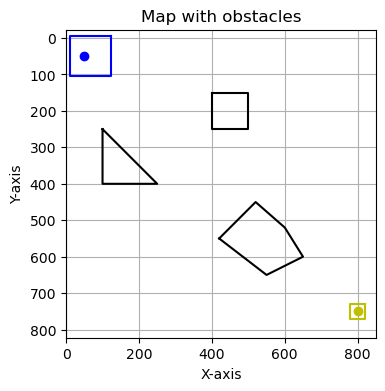

In [20]:
# First processing of the obstacles to make sure vertices are ordered (counterclockwise)
obs_list = sort_obstacle_vertices(obs_list)

# Representing Thymio and goal by their 4 vertices
pos_Thymio = [start_point[0], start_point[1], robot_dir0]
width_goal = width_goal
widths_Thymio = thymio_dimensions
start_pos, goal_pos = get_vertices_from_uniqpoint(goal_point, pos_Thymio, width_goal, widths_Thymio)

# Plot the map with obstacles
print('Schematic map :')
plot_map(obs_list, xLimMap, yLimMap, start=start_pos, start_pt=start_point, goal=goal_pos)

We expand obstacles, making them $\texttt{width}$ bigger. As mentioned above, the obstacles are supposed sufficiently far from each other so that the resulting shapes don't intersect, because their vertices will be used to determine visibility and construct visibility graph.

Schematic map with expanded obstacles :


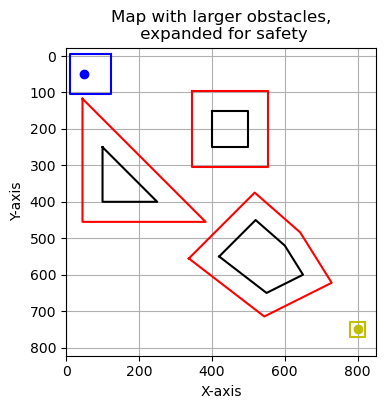

Coordinates of expanded obstacles' vertices : 
 (put together in a list in the code)
 - Obstacle  0
[[345.  95.]
 [345. 305.]
 [555. 305.]
 [555.  95.]]
 - Obstacle  1
[[ 45.  117.2]
 [ 45.  455. ]
 [382.8 455. ]]
 - Obstacle  2
[[336.8 555.4]
 [543.8 714.6]
 [728.7 622.1]
 [642.3 484. ]
 [517.5 374.7]]


In [6]:
# Expand obstacles (ideally by at least half of Thymio robot's width)
expanded_obs = expand_obstacles(obs_list, width) # expanded_obs is now a list of #obs lists of #verticesofthisobs tuples

print('Schematic map with expanded obstacles :')
plot_map(obs_list, xLimMap, yLimMap, True, expanded_obs, start=start_pos, start_pt=start_point, goal=goal_pos)

print("""Coordinates of expanded obstacles' vertices : \n (put together in a list in the code)""")
for obs in range(len(expanded_obs)) :
    print(' - Obstacle ', obs)
    print(*[np.round(expanded_obs[obs], 1)])

These coordinates of the vertices of the expanded obstacles will be part of the output of the $\texttt{findPath}$ function, to plot them on the image from the camera (in live visualisation).

### b) Construct the visibility graph
We determine whether vertices are visible or not from each other by checking if the segment between them intersects at least one of the edges of the obstacles. If it is the case, these nodes don't see each other. If not, we found a visible node. 

This is the reason why we assumed we had only convex obstacles, because the code doesn't handle visible vertices from the same obstacles.

It may seem unefficient, but it's surprisingly fast, especially when comparing to vision$^1$. 

$^1$The ideas on how to determine visibility relations between vertices are inspired by this website : https://www.science.smith.edu/~istreinu/Teaching/Courses/274/Spring98/Projects/Philip/fp/visibility.htm

Visible vertices from each node :
0 [1, 2, 4, 5, 7]
1 [0, 4, 2, 5]
2 [0, 1, 3, 5, 7, 12]
3 [2, 4, 7, 8, 10, 11, 12, 13]
4 [0, 3, 1, 10, 11, 13]
5 [0, 1, 2, 7, 6]
6 [5, 7, 8, 9]
7 [0, 2, 3, 6, 5, 8, 12]
8 [3, 6, 7, 12, 9]
9 [6, 8, 10, 13]
10 [3, 4, 9, 11, 13]
11 [3, 4, 10, 12]
12 [2, 3, 7, 11, 8]
13 [3, 4, 9, 10]


Map with visibility visualisation :
 (violet lines show visibility relations)


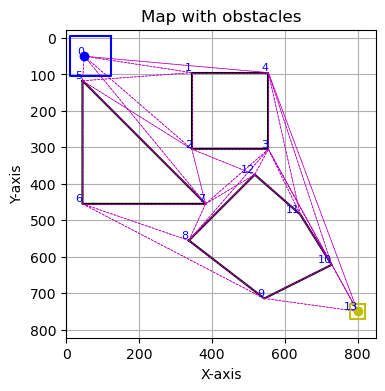

In [7]:
# Get 
# myNodes, nodes' indices (identifiers)
# myVertices, corresponding vertices' coordinates
# mySides, sides of obstacles described by the nodes' indices of the 2 endpoints
myNodes, myVertices, mySides = get_nodes_and_sides(expanded_obs, start_point, goal_point)
        
myEdges, myWeights = get_edges_and_weights(myNodes, myVertices, mySides, verbose=True)

print("Map with visibility visualisation :\n (violet lines show visibility relations)")
plot_map(expanded_obs, xLimMap, yLimMap, larger=False, larger_obs=None, 
     start=start_pos, start_pt=start_point, goal=goal_pos,
     graph=True, graph_edges=myEdges, vertices=myVertices)

Weighted graph :


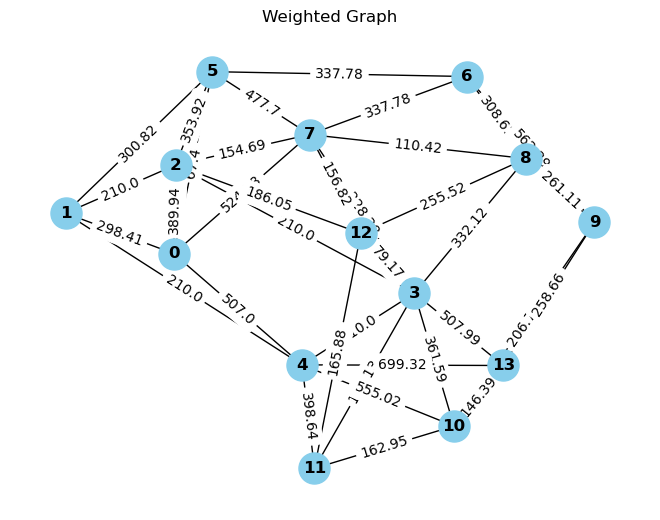

In [8]:
# Visualize the weighted graph. We know it's not possible to find the best path at sight in this graph,
# it's here to illustrate the chosen method.
myGraph = create_graph(myNodes, myEdges, myWeights, verbose=True)

### c) Find shortest path in graph, using Dijkstra's algorithm

In [9]:
# As said before, we used the already implemented version of the algorithm, from networkx library
myPath = nx.dijkstra_path(myGraph, 0, myNodes[-1][0], weight='weight')
print('Path nodes :', myPath)

Path nodes : [0, 2, 12, 11, 10, 13]


### d) Convertion from nodes in graph to x,y coordinates :

In [10]:
# Getting coordinates of the points we want to go through
myCoordinates = get_wheretogo_coordinates(myPath, myVertices)
print('Path points coordinates :')
print(myCoordinates)

Path points coordinates :
[[50, 50], [345.0, 305.0], [517.4936034837497, 374.7246505857302], [642.3331586069959, 483.95926131857067], [728.6979342066032, 622.1429022779425], [800, 750]]


## 4. Motion and Thymio's instructions <a class="anchor" id="fourth-bullet"></a>
### a) Choices explanations
The motion algorithm involves a combination of trajectory following and obstacle avoidance to allow the robot to navigate along a path found by the visibility graph and pathfinding part.

<center>

![Finite state machine of the motion control](images/motion_state_machine.jpg)

</center>

The motion of the robot is described in the finite state machine above. In the state **rotation**, the robot rotates until it is oriented to the direction of the next trajectory point. In the state **Follow trajectory**, the robot follows the line between two consecutive trajectory points.  

The addition of the state **rotation** induces a better trajectory overall and allows the robot to pass between two obstacle positioned closer than if only a controller (like a pid controller) was implemented. Indeed, without this state, the robot would take more time to correct its trajectory and potentially hurt another obstacle as we can observe on the image below.

<center>

![Motion with and without Rotation state](images/motion_schema.jpg)

</center>

### b) Implementation of the function motion

In [11]:
def motion(estimated_pos,pos_goal,prox_horizontal, Tm): 
    
    #local variables 
    output_speed_l=0 
    output_speed_r=0
    end = False
    
    #static variables
    if not hasattr(motion, "idx"):
        # If not, initialize idx to 0
        motion.idx = 0
    if not hasattr(motion, "mot_state"):
        # If not, initialize mot_state to the state ROTATION
        motion.mot_state = motion_state.ROTATION
        
    angle_goal,angle_goal_live = calcul_angle(pos_goal, estimated_pos, motion.idx)
        
    if motion.idx<len(angle_goal):
        distance,angle = relative_pos(estimated_pos,pos_goal,motion.idx)
        angle = normalize_angle(angle)

        #Rotate until the robot reach the direction of the next trajectory point/position goal
        if motion.mot_state == motion_state.ROTATION:
            angle_rot = angle_goal[motion.idx]-angle
            if angle_rot > 180:
                angle_rot = angle_rot-360
            elif angle_rot < -180:
                angle_rot = angle_rot+360
            if angle_rot<=0: #turn in counterclockwise
                output_speed_l = -(SPEED_ROT) 
                output_speed_r = SPEED_ROT
            else: #turn in clockwise
                output_speed_l = SPEED_ROT
                output_speed_r = -(SPEED_ROT)
            if abs(angle_rot)<ROTATION_TRESHOLD:
                motion.mot_state = motion_state.FOLLOW_TRAJECTORY

        #Move from a point the following point given by the visibility map   
        if motion.mot_state == motion_state.FOLLOW_TRAJECTORY:
            output_speed_l, output_speed_r = motors_correction(prox_horizontal, angle_goal_live, angle)
            if distance <= DISTANCE_TRESHOLD:
                output_speed_l = 0 
                output_speed_r = 0
                motion.mot_state = motion_state.ROTATION
                motion.idx += 1  
                
    else:
        output_speed_l = 0 
        output_speed_r = 0
        end = True
        
    delta_distance, delta_angle = delta_pos(output_speed_l, output_speed_r,Tm)
    
    return output_speed_l, output_speed_r,delta_distance, delta_angle,end 
    

### c) P controller
During the state **Follow trajectory**, a P controller has been implemented to correct the angle error produced by the state rotation and to redirect the robot to the right direction after a local avoidance.

<center>

![P controller](images/p_controller_schema.jpg)

</center>

#### P controller implementation :

In [1]:
def p_controller(angle,angle_goal):
    angle_error = angle-angle_goal
    if angle_error > 180:
        angle_error = angle_error - 360
    if angle_error < -180:
        angle_error = angle_error + 360
    corr_l = - KP*angle_error
    corr_r =  KP*angle_error
    corr_l = int(corr_l)
    corr_r = int(corr_r)
    return corr_l, corr_r

## 5. Local avoidance <a class="anchor" id="fifth-bullet"></a>
For the obstacle avoidance, an artificial neural network has been implemented between the proximity sensors and the motors as we can observe on the image below. The implementation is similar as the activity 1 of TP3.

<center>

![ANN between motors and proximity sensors](images/ANN_schema.jpg)

</center>

### a) Implementation of the ANN and P controller

In [13]:
# Artificial neural network between the proximity sensors and the motors

#ANN CONSTANTS
WR = [-80,-80,-80,-40,60,0,0] 
WL = [60,-40,-80,-80,-80,0,0] 

def avoid_obstacle(prox_horizontal):
    y = [0,0]
    x = [0,0,0,0,0,0,0]
    for i in range (len(x)):
        x[i]= prox_horizontal[i]//SENSOR_SCALE
        y[0] = y[0]+WL[i]*x[i]
        y[1] = y[1]+WR[i]*x[i]
   
    corr_speed_l = y[0]//MOTOR_SCALE
    corr_speed_r = y[1]//MOTOR_SCALE
    return corr_speed_l, corr_speed_r


# Correction of the motors speed
def motors_correction(prox_horizontal,angle_goal,angle): 
    avoid_speed_l,avoid_speed_r = avoid_obstacle(prox_horizontal)
    p_corr_l, p_corr_r = p_controller(angle,angle_goal)
    speed_l = SPEED + avoid_speed_l + p_corr_l
    speed_r = SPEED + avoid_speed_r + p_corr_r
    return speed_l,speed_r


## 6. Filtering <a class="anchor" id="sixth-bullet"></a>

### a) Speed factor and variance
To design a Kalman filter, we need to know the speed variance and angular speed variance. To compute these variances and the speed factor used to convert thymio speed to mm/s, the same method as the one used in chapter 4 of the TP8.
Here are the results obtained using this method:
#### Black stripes used for the calibration
<center>
    
![Black stripes](images/black_stripes.jpg)
    
</center>

In [14]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm

In [15]:
thymio_data = [{'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -4, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -4, 'right_speed': -36}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -34}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -34}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -36}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -36}, {'ground': [110, 46], 'sensor': [110, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -4, 'right_speed': -36}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -34}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -36}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [110, 46], 'sensor': [110, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -18}, {'ground': [109, 47], 'sensor': [109, 47], 'left_speed': -3, 'right_speed': -34}, {'ground': [109, 47], 'sensor': [109, 47], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 47], 'sensor': [109, 47], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -36}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': 0, 'right_speed': -36}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -1, 'right_speed': -35}, {'ground': [109, 46], 'sensor': [109, 46], 'left_speed': -2, 'right_speed': 4}, {'ground': [107, 45], 'sensor': [107, 45], 'left_speed': 38, 'right_speed': 34}, {'ground': [109, 45], 'sensor': [109, 45], 'left_speed': 41, 'right_speed': 46}, {'ground': [118, 47], 'sensor': [118, 47], 'left_speed': 45, 'right_speed': 47}, {'ground': [121, 44], 'sensor': [121, 44], 'left_speed': 54, 'right_speed': 49}, {'ground': [120, 45], 'sensor': [120, 45], 'left_speed': 57, 'right_speed': 47}, {'ground': [113, 43], 'sensor': [113, 43], 'left_speed': 54, 'right_speed': 49}, {'ground': [181, 62], 'sensor': [181, 62], 'left_speed': 51, 'right_speed': 50}, {'ground': [345, 124], 'sensor': [345, 124], 'left_speed': 54, 'right_speed': 50}, {'ground': [429, 169], 'sensor': [429, 169], 'left_speed': 53, 'right_speed': 50}, {'ground': [393, 192], 'sensor': [393, 192], 'left_speed': 53, 'right_speed': 50}, {'ground': [334, 197], 'sensor': [334, 197], 'left_speed': 52, 'right_speed': 51}, {'ground': [189, 129], 'sensor': [189, 129], 'left_speed': 52, 'right_speed': 51}, {'ground': [115, 55], 'sensor': [115, 55], 'left_speed': 50, 'right_speed': 52}, {'ground': [106, 42], 'sensor': [106, 42], 'left_speed': 50, 'right_speed': 50}, {'ground': [104, 42], 'sensor': [104, 42], 'left_speed': 49, 'right_speed': 50}, {'ground': [102, 43], 'sensor': [102, 43], 'left_speed': 48, 'right_speed': 47}, {'ground': [94, 43], 'sensor': [94, 43], 'left_speed': 46, 'right_speed': 46}, {'ground': [101, 43], 'sensor': [101, 43], 'left_speed': 46, 'right_speed': 47}, {'ground': [107, 42], 'sensor': [107, 42], 'left_speed': 47, 'right_speed': 46}, {'ground': [124, 46], 'sensor': [124, 46], 'left_speed': 46, 'right_speed': 46}, {'ground': [251, 86], 'sensor': [251, 86], 'left_speed': 46, 'right_speed': 47}, {'ground': [411, 150], 'sensor': [411, 150], 'left_speed': 45, 'right_speed': 50}, {'ground': [428, 181], 'sensor': [428, 181], 'left_speed': 46, 'right_speed': 54}, {'ground': [371, 201], 'sensor': [371, 201], 'left_speed': 44, 'right_speed': 58}, {'ground': [258, 168], 'sensor': [258, 168], 'left_speed': 48, 'right_speed': 61}, {'ground': [127, 74], 'sensor': [127, 74], 'left_speed': 47, 'right_speed': 57}, {'ground': [103, 45], 'sensor': [103, 45], 'left_speed': 47, 'right_speed': 50}, {'ground': [101, 44], 'sensor': [101, 44], 'left_speed': 44, 'right_speed': 46}, {'ground': [105, 40], 'sensor': [105, 40], 'left_speed': 41, 'right_speed': 43}, {'ground': [106, 41], 'sensor': [106, 41], 'left_speed': 41, 'right_speed': 41}, {'ground': [108, 43], 'sensor': [108, 43], 'left_speed': 44, 'right_speed': 44}, {'ground': [104, 43], 'sensor': [104, 43], 'left_speed': 46, 'right_speed': 47}, {'ground': [100, 45], 'sensor': [100, 45], 'left_speed': 49, 'right_speed': 53}, {'ground': [169, 63], 'sensor': [169, 63], 'left_speed': 55, 'right_speed': 58}, {'ground': [338, 125], 'sensor': [338, 125], 'left_speed': 53, 'right_speed': 59}, {'ground': [422, 173], 'sensor': [422, 173], 'left_speed': 61, 'right_speed': 54}, {'ground': [381, 198], 'sensor': [381, 198], 'left_speed': 57, 'right_speed': 50}, {'ground': [168, 194], 'sensor': [168, 194], 'left_speed': 59, 'right_speed': 50}, {'ground': [168, 120], 'sensor': [168, 120], 'left_speed': 58, 'right_speed': 43}, {'ground': [168, 120], 'sensor': [168, 120], 'left_speed': 58, 'right_speed': 43}, {'ground': [113, 49], 'sensor': [113, 49], 'left_speed': 49, 'right_speed': 40}, {'ground': [104, 40], 'sensor': [104, 40], 'left_speed': 47, 'right_speed': 42}, {'ground': [99, 42], 'sensor': [99, 42], 'left_speed': 44, 'right_speed': 46}, {'ground': [103, 42], 'sensor': [103, 42], 'left_speed': 44, 'right_speed': 49}, {'ground': [105, 42], 'sensor': [105, 42], 'left_speed': 44, 'right_speed': 49}, {'ground': [115, 40], 'sensor': [115, 40], 'left_speed': 46, 'right_speed': 51}, {'ground': [142, 47], 'sensor': [142, 47], 'left_speed': 44, 'right_speed': 55}, {'ground': [281, 47], 'sensor': [281, 47], 'left_speed': 45, 'right_speed': 56}, {'ground': [431, 97], 'sensor': [431, 97], 'left_speed': 45, 'right_speed': 57}, {'ground': [428, 201], 'sensor': [428, 201], 'left_speed': 45, 'right_speed': 56}, {'ground': [376, 214], 'sensor': [376, 214], 'left_speed': 45, 'right_speed': 55}, {'ground': [239, 159], 'sensor': [239, 159], 'left_speed': 45, 'right_speed': 53}, {'ground': [131, 65], 'sensor': [131, 65], 'left_speed': 45, 'right_speed': 51}, {'ground': [113, 42], 'sensor': [113, 42], 'left_speed': 45, 'right_speed': 50}, {'ground': [106, 43], 'sensor': [106, 43], 'left_speed': 46, 'right_speed': 50}, {'ground': [106, 41], 'sensor': [106, 41], 'left_speed': 47, 'right_speed': 53}, {'ground': [108, 44], 'sensor': [108, 44], 'left_speed': 47, 'right_speed': 51}, {'ground': [110, 44], 'sensor': [110, 44], 'left_speed': 47, 'right_speed': 51}, {'ground': [109, 42], 'sensor': [109, 42], 'left_speed': 47, 'right_speed': 51}, {'ground': [108, 43], 'sensor': [108, 43], 'left_speed': 48, 'right_speed': 52}, {'ground': [192, 72], 'sensor': [192, 72], 'left_speed': 49, 'right_speed': 53}, {'ground': [368, 143], 'sensor': [368, 143], 'left_speed': 49, 'right_speed': 52}, {'ground': [444, 184], 'sensor': [444, 184], 'left_speed': 51, 'right_speed': 52}, {'ground': [398, 207], 'sensor': [398, 207], 'left_speed': 52, 'right_speed': 51}, {'ground': [313, 189], 'sensor': [313, 189], 'left_speed': 54, 'right_speed': 51}, {'ground': [121, 44], 'sensor': [121, 44], 'left_speed': 56, 'right_speed': 47}, {'ground': [120, 41], 'sensor': [120, 41], 'left_speed': 54, 'right_speed': 45}, {'ground': [114, 44], 'sensor': [114, 44], 'left_speed': 53, 'right_speed': 45}, {'ground': [110, 45], 'sensor': [110, 45], 'left_speed': 54, 'right_speed': 46}, {'ground': [105, 44], 'sensor': [105, 44], 'left_speed': 55, 'right_speed': 44}, {'ground': [103, 43], 'sensor': [103, 43], 'left_speed': 52, 'right_speed': 45}, {'ground': [106, 43], 'sensor': [106, 43], 'left_speed': 54, 'right_speed': 45}, {'ground': [147, 57], 'sensor': [147, 57], 'left_speed': 50, 'right_speed': 47}, {'ground': [309, 120], 'sensor': [309, 120], 'left_speed': 51, 'right_speed': 47}, {'ground': [459, 173], 'sensor': [459, 173], 'left_speed': 52, 'right_speed': 53}, {'ground': [442, 198], 'sensor': [442, 198], 'left_speed': 51, 'right_speed': 54}, {'ground': [377, 202], 'sensor': [377, 202], 'left_speed': 51, 'right_speed': 52}, {'ground': [220, 135], 'sensor': [220, 135], 'left_speed': 50, 'right_speed': 53}, {'ground': [127, 55], 'sensor': [127, 55], 'left_speed': 51, 'right_speed': 53}, {'ground': [117, 43], 'sensor': [117, 43], 'left_speed': 50, 'right_speed': 52}, {'ground': [118, 43], 'sensor': [118, 43], 'left_speed': 50, 'right_speed': 50}, {'ground': [117, 44], 'sensor': [117, 44], 'left_speed': 48, 'right_speed': 50}, {'ground': [117, 44], 'sensor': [117, 44], 'left_speed': 46, 'right_speed': 49}, {'ground': [114, 42], 'sensor': [114, 42], 'left_speed': 43, 'right_speed': 48}, {'ground': [112, 42], 'sensor': [112, 42], 'left_speed': 42, 'right_speed': 47}, {'ground': [117, 43], 'sensor': [117, 43], 'left_speed': 41, 'right_speed': 47}, {'ground': [228, 88], 'sensor': [228, 88], 'left_speed': 41, 'right_speed': 48}, {'ground': [436, 166], 'sensor': [436, 166], 'left_speed': 43, 'right_speed': 51}, {'ground': [492, 207], 'sensor': [492, 207], 'left_speed': 46, 'right_speed': 56}, {'ground': [433, 228], 'sensor': [433, 228], 'left_speed': 56, 'right_speed': 56}, {'ground': [295, 186], 'sensor': [295, 186], 'left_speed': 58, 'right_speed': 54}, {'ground': [146, 85], 'sensor': [146, 85], 'left_speed': 57, 'right_speed': 53}, {'ground': [110, 45], 'sensor': [110, 45], 'left_speed': 58, 'right_speed': 51}, {'ground': [104, 42], 'sensor': [104, 42], 'left_speed': 56, 'right_speed': 41}, {'ground': [101, 40], 'sensor': [101, 40], 'left_speed': 54, 'right_speed': 41}, {'ground': [102, 40], 'sensor': [102, 40], 'left_speed': 55, 'right_speed': 40}, {'ground': [101, 41], 'sensor': [101, 41], 'left_speed': 54, 'right_speed': 42}, {'ground': [104, 40], 'sensor': [104, 40], 'left_speed': 51, 'right_speed': 49}, {'ground': [111, 42], 'sensor': [111, 42], 'left_speed': 51, 'right_speed': 53}, {'ground': [155, 58], 'sensor': [155, 58], 'left_speed': 49, 'right_speed': 53}, {'ground': [329, 120], 'sensor': [329, 120], 'left_speed': 54, 'right_speed': 52}, {'ground': [466, 173], 'sensor': [466, 173], 'left_speed': 52, 'right_speed': 54}, {'ground': [438, 202], 'sensor': [438, 202], 'left_speed': 55, 'right_speed': 55}, {'ground': [366, 207], 'sensor': [366, 207], 'left_speed': 49, 'right_speed': 53}, {'ground': [205, 137], 'sensor': [205, 137], 'left_speed': 47, 'right_speed': 48}, {'ground': [116, 57], 'sensor': [116, 57], 'left_speed': 43, 'right_speed': 43}, {'ground': [109, 43], 'sensor': [109, 43], 'left_speed': 40, 'right_speed': 40}, {'ground': [114, 42], 'sensor': [114, 42], 'left_speed': 40, 'right_speed': 43}, {'ground': [113, 43], 'sensor': [113, 43], 'left_speed': 44, 'right_speed': 50}, {'ground': [115, 43], 'sensor': [115, 43], 'left_speed': 48, 'right_speed': 57}, {'ground': [113, 44], 'sensor': [113, 44], 'left_speed': 51, 'right_speed': 60}, {'ground': [113, 46], 'sensor': [113, 46], 'left_speed': 57, 'right_speed': 60}, {'ground': [131, 50], 'sensor': [131, 50], 'left_speed': 59, 'right_speed': 55}, {'ground': [263, 92], 'sensor': [263, 92], 'left_speed': 61, 'right_speed': 49}, {'ground': [423, 156], 'sensor': [423, 156], 'left_speed': 56, 'right_speed': 45}]

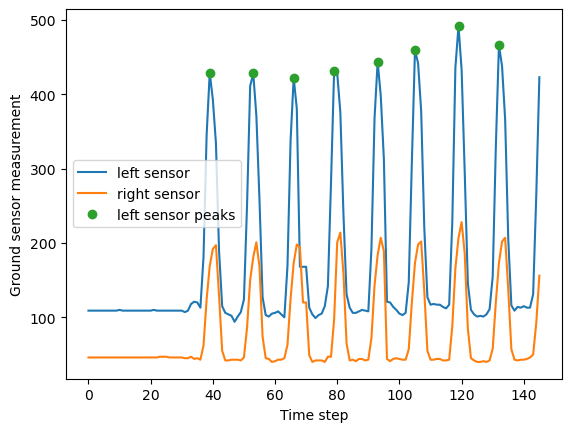

In [16]:
Ts = 0.1
l_sensor = [x["ground"][0] for x in thymio_data]
r_sensor = [x["ground"][1] for x in thymio_data]
avg_ground = [(l+r)/2 for l, r in zip(l_sensor, r_sensor)]
l_peaks = find_peaks(l_sensor, 110, 3 )[0]

plt.plot(l_sensor, label="left sensor")
plt.plot(r_sensor, label="right sensor")
plt.plot(l_peaks, [l_sensor[idx] for idx in l_peaks], "o", label = "left sensor peaks")
plt.xlabel("Time step")
plt.ylabel("Ground sensor measurement")
plt.legend()

In [17]:
#Provided the constant sampling time, we can estimate how much time it took the Thymio to cross the 9 peaks, i.e. 8 stripes, with each stripe measuring 22mm.
thymio_mms_speed = 8*22/Ts/(l_peaks[-1]-l_peaks[0])
print("The Thymio's speed in mm/s is {}".format(thymio_mms_speed))

#conversion factor to go from thymio speed to mm/s
thymio_speed_to_mms = thymio_mms_speed/50
print("To go from Thymio speed to mm/s, the conversion factor is {}".format(thymio_speed_to_mms))

The Thymio's speed in mm/s is 18.9247311827957
To go from Thymio speed to mm/s, the conversion factor is 0.378494623655914


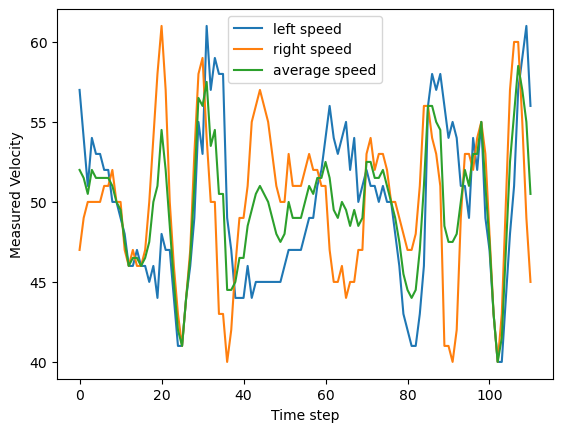

In [18]:
# plot of the croped data from measured velocity
l_speed = [x["left_speed"] for x in thymio_data]
r_speed = [x["right_speed"] for x in thymio_data]
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data]
plt.plot(l_speed[35:], label="left speed")
plt.plot(r_speed[35:], label="right speed")
plt.plot(avg_speed[35:], label="average speed")
plt.xlabel("Time step")
plt.ylabel("Measured Velocity")
plt.legend()

In [19]:
WHEEL_RADIUS = 22 #mm
var_speed = np.var(avg_speed[35:]/thymio_speed_to_mms)
std_speed = np.std(avg_speed[35:]/thymio_speed_to_mms)
std_speed_rot = std_speed/WHEEL_RADIUS**2
print("The speed variance in mm^2/s^2 is {}".format(std_speed))
print("The angular speed variance in rad^2/s^2 is {}".format(std_speed_rot))

The speed variance in mm^2/s^2 is 9.461236777090114
The angular speed variance in rad^2/s^2 is 0.019548009870020897


### b) Kalman Filter

#### Theoritical explanation
We have implemented a basic Kalman Filter for state estimation. The Kalman Filter is a mathematical method that uses measurements observed over time containing statistical noise and other inaccuracies to produce estimates of unknown variables that tend to be more precise than those based on a single measurement alone. In our case, it is used to merge together the odometer and the camera measurement.

**Kalman Filter Implementation**
The Kalman Filter (KF) is a powerful tool for integrating different sources of data to estimate the state of a dynamic system. In our implementation, we focus on combining data from a camera and a wheel sensor to determine the position and orientation of a robot.

**Input Data**
We gather two primary types of input data:
1. **Camera Data** $z^t_{camera}$: This consists of the state of the robot given by the camera under the form: $(x,y,\alpha)$ with $(x,y)$ the center of rotation of the robot.
2. **Wheel Data** $x^t_{wheel}$: This data includes delta distance ($\Delta d$) and delta angle ($\Delta \alpha$) covered over a time $T_m$, measured in millimeters and degrees, respectively, represented as $rawdata_{wheel} = (\Delta d,\Delta \alpha)$.

**Predict Step**
The predict step of the Kalman Filter involves estimating the robot's next state, $\hat{x}_{k}$, based on the previous state, $x_{k-1}$, and control inputs, $u_k$, which come from wheel data. The equations are as follows:
- State Prediction: $\hat{x}_{k} = F_k x_{k-1} + B_{k} u_k$
- Covariance Prediction: $P_{k} = F_k P_{k-1} F_k^T + Q_k$

Here, 
- $\hat{x}_{k}$ represents the estimated state vector (position and orientation), expressed as $\hat{x}_{k} = \begin{pmatrix} \hat{x}_{k} \\ \hat{y}_{k} \\ \hat{\alpha}_{k} \end{pmatrix}$.
- $F_k$ is the state transition matrix, assumed to be an identity matrix for simplicity, denoted by $F_k = \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0 \\ 0 & 0 & 1 \end{pmatrix}$.
- $B_k$ is the control input model, incorporating the robot's motion characteristics, represented as $B_k = \begin{pmatrix} \sin(\alpha) & 0 \\ \cos(\alpha) & 0 \\ 0 & 1 \end{pmatrix}$.
- $Q_k$ is the covariance of wheel measurements, which needs to be determined.

**Update Step**
The update step involves correcting the predicted state using camera data:
- Innovation or Measurement Residual: $y_k = z_k - H_k \hat{x}_k$
- Innovation Covariance: $S_k = H_k P_k H_k^T + R_k$
- Kalman Gain: $K_k = P_k H_k^T S_k^{-1}$
- Updated State Estimate: $\hat{x}_k = \hat{x}_k + K_k y_k$
- Updated Covariance Estimate: $P_k = (I - K_k H_k) P_k$

In this step, 
- $H_k$ represents how the measurement relates to the state. It needs to be defined based on your measurement model.
- $z_k$ is the actual measurement from the camera.
- $R_k$ is the covariance of the camera measurements, which needs to be determined.

By combining these two steps—predict and update—the Kalman Filter effectively fuses data from both the camera and wheel sensors to accurately track the robot's position and orientation, even in the presence of noise and uncertainties in measurements.

#### Implementation explanation
1. **Initialization of Matrices**:
   - `F` is the state transition matrix, which is used to predict the next state of the system given the current state.
   - `P` is the initial prediction covariance matrix, representing the initial uncertainty of the state estimate.
   - `H` is the measurement matrix used to map the true state space into the observed space.
   - `Q` is the process noise covariance matrix, indicating the process's uncertainty.
   - `R` is the measurement noise covariance matrix, representing the uncertainty in sensor measurements.\\

2. **Kalman Filter Functions**:
   - `kalman`: Main function to estimate the position. It takes raw measurements from the wheel and camera, the estimated position, time, and previous estimate covariance as inputs. It predicts the next state using `kalman_predict` and updates the estimate with `kalman_update` if a camera measurement is available.
   - `B_kalman`: Generates a specific matrix `B` based on the current state, used in the prediction step.
   - `kalman_predict`: Performs the prediction step of the Kalman Filter. It updates the state estimate `x_hat` and the estimate covariance `P_hat` based on the input control `u` and time `Tm`.
   - `kalman_update`: Updates the predicted state `x_hat_pred` and covariance `P_pred` using the new measurement `raw_camera_measurement`.
   - `Q_update`: Dynamically updates the process noise covariance matrix `Q` based on the current state and time interval `dt`.

This implementation ensures the state estimate's angle remains within the range of -180 to 180 degrees, accounting for the periodic nature of angular measurements.


## 7. Complete implementation <a class="anchor" id="seven-bullet"></a>

Finally, we put together these 5 parts to get our complete implementation. It can be found in the notebook $\texttt{main.ipynb}$.

## 8. Conclusion <a class="anchor" id="eight-bullet"></a>

#### a) Performance analysis
This section aims to assess the robustness of our implementation to certain changes.
- Various lightning : Our code is quite robust to change in lightning because it doesn't use any color detection.
- Various position of camera : The camera doesn't need to be centered on the map (but it needs to see the 4 corners).
- Various obstacles' shapes : The obstacles can have arbitrary number of edges, as long as they are polygons.

#### b) Limitations and potential improvements
- The obstacles are assumed to be convex polygons. With a bit more time, we could adapt the code so that it allows for concave shapes as well. The only part that would require an update is the construction of the visibility graph.
- To improve performance of our robot, we could add a PID-controller, instead of the P-controller.


### Appendix : sources <a class="anchor" id="appendix-bullet"></a>
- Visibility graphs : https://www.science.smith.edu/~istreinu/Teaching/Courses/274/Spring98/Projects/Philip/fp/visibility.htm
- Dijkstra algorithm on weighted graph, imported from library networkx : https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.shortest_paths.weighted.dijkstra_path.html
- ChatGPT for small functions, for creating python plots, etc.